In [182]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
import copy
import scipy.fftpack as sfft
from scipy.optimize import minimize
from scipy.ndimage import zoom
from skimage import restoration
import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)

In [184]:
data = eleanor.TargetData(star, height=15, width=15, do_pca=True, do_psf=False)

In [185]:
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
tpfs = sc.flux[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end]
bkg0 = np.mean(bkgs).value

In [186]:
xc = [4.9, 4.5, 4.7]
yc = [3.0, 4.4, 7.0]
aperture_fluxes = data.get_aperture_fluxes(xc=xc, yc=yc, data_arr=tpfs)

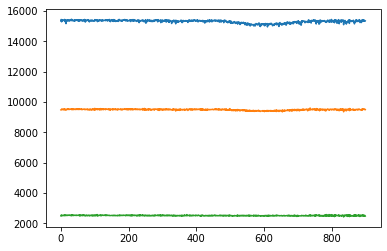

In [54]:
plt.plot(aperture_fluxes)

In [180]:
# first, get the PSF and fit it to a single Gaussian or Moffat with individual drifts
def aperture_deltas(xc, yc, bkg0=0):
    """
    Based on center information and aperture flux, 
    makes a model of what the TPF would look like with a deconvolved PSF.
    """
    deconv_tpf_model = np.zeros_like(tpfs) + bkg0
    for i, (x, y) in enumerate(zip(xc, yc)):
        xl, yl, wts = data.cutout_weights(x, y)
        print(xl, yl)
        deconv_tpf_model[:, yl:yl+2, xl:xl+2] += np.array([f * wts for f in aperture_fluxes[:,i]])
    
    return deconv_tpf_model

deltas = aperture_deltas(xc, yc, bkg0)

TypeError: 'numpy.float64' object is not iterable

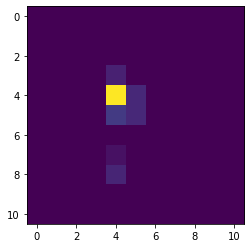

In [179]:
plt.imshow(deltas[0])

In [177]:
deltas_ft = np.array([sfft.fft2(d) for d in deltas])
tpfs_ft = np.array([sfft.fft2(t) for t in tpfs])
ft_ratios = np.array([sfft.fft2(tf / df) for tf, df in zip(tpfs_ft, deltas_ft)])
psfs = np.array([sfft.fftshift(r.real ** 2 + r.imag ** 2) for r in ft_ratios])

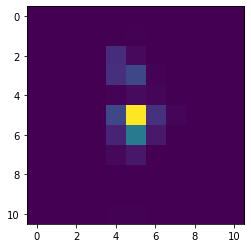

In [178]:
avg_psf = np.mean(psfs, axis=0) / np.mean(psfs)
plt.imshow(avg_psf)

In [162]:
y_grid, x_grid = np.mgrid[:11, :11]
log_avg_psf = np.log(avg_psf)

def loss(p):
    # Gaussian, for now
    a, b, c, xs, ys = p
    dx = x_grid - xs
    dy = y_grid - ys
    return np.sum((avg_psf - np.exp(-(a * dx ** 2 + 2 * b * dx * dy * c * dy ** 2))) ** 2)

In [163]:
psfoptpars = minimize(loss, [1, 0, 1, 11 // 2 + 1, 11 // 2 + 1], method='Nelder-Mead').x

In [124]:
# I think this is overfitting and is also biased in some way i can't see yet, so leaving it aside for now

def drift_loss(pos, i):
    xs, ys = pos
    a, b, c, xo, yo = psfoptpars
    dx = x_grid - (xs + xo)
    dy = y_grid - (ys + yo)
    return np.sum((np.log(psfs[i]) + a * dx ** 2 + 2 * b * dx * dy * c * dy ** 2) ** 2)
    
xs, ys = np.zeros(len(tpfs)) + psfoptpars[3], np.zeros(len(tpfs)) + psfoptpars[4]
for i in tqdm.trange(len(tpfs)):
    drifts = minimize(drift_loss, [0, 0], i).x
    xs[i] += drifts[0]
    ys[i] += drifts[1]

100%|██████████| 900/900 [00:13<00:00, 68.68it/s]


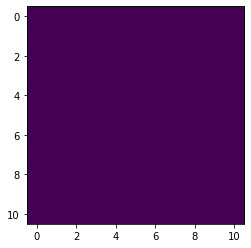

In [164]:
a, b, c, xc, yc = psfoptpars
dx = x_grid - xc
dy = y_grid - yc
plt.imshow(np.exp(-a * dx ** 2 - 2 * b * dx * dy - c * dy ** 2))

In [165]:
psfoptpars

array([ 2.04864679e-01, -3.88169009e-08,  7.98906916e+01,  7.14218098e+00,
        5.64506404e+01])